# <a id='toc1_'></a>[Data Exploration](#toc0_)
Within this Mini Challenge the goal is to build a RAG system in the context of "clean technology" (Cleantech).

The dataset being used to retrieve information from is the [Cleantech Media Dataset](https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset) on Kaggle. 

**Table of contents**<a id='toc0_'></a>    

  - [Setup](#toc1_1_1_)    
  - [Getting an Overview](#toc1_2_)    
  - [Content Structure](#toc1_3_)    
    - [Frequency of Publishers](#toc1_3_1_)    
  - [Taking a closer look at titles](#toc1_4_)    
  - [Analyzing Languages](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Setup](#toc0_)

In [2]:
import ast
import pandas as pd
import plotly.graph_objects as go
from langdetect import detect, LangDetectException
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_FOLDER = '../data/Cleantech Media Dataset'

## <a id='toc1_2_'></a>[Getting an Overview](#toc0_)

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/cleantech_media_dataset_v2_2024-02-23.csv')
df.head()

,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


The dataset consists of `7` columns. The column `content` contains what looks like a list of *prechunked* segments. 

In [4]:
columns = df.columns
total_counts = df.count()
nan_counts = df.isna().sum()
unique_counts = df.nunique()

nan_percentages = (nan_counts / len(df)) * 100
unique_percentages = (unique_counts / len(df)) * 100

data = {
    'Total Count': total_counts,
    'NaN Count': nan_counts,
    'NaN Percentage (%)': nan_percentages,
    'Unique Count': unique_counts,
    'Unique Percentage (%)': unique_percentages
}
summary_df = pd.DataFrame(data, index=columns)

summary_df

,Total Count,NaN Count,NaN Percentage (%),Unique Count,Unique Percentage (%)
Unnamed: 0,9593,0,0.000000,9593,100.000000
title,9593,0,0.000000,9569,99.749818
date,9593,0,0.000000,967,10.080267
author,31,9562,99.676848,7,0.072970
content,9593,0,0.000000,9588,99.947879
domain,9593,0,0.000000,19,0.198061
url,9593,0,0.000000,9593,100.000000


Some Key Takeaways of the columns summary are:
- Most columns are fully populated with no missing values (NaN Count is 0 for most columns). This suggests the dataset is quite clean and comprehensive, except for the author column which only has `31` non-NaN values.
- The `Unnamed: 0` (Id) and `url` columns are completely unique across all entries (Unique Percentage of 100%). This is a good sign especially for `Unnamed: 0` which seems to serve as a unique identifier for all documents in the dataset.
- The title column is not completely unique (99.75% unique). An assumption would've been that it is 100% unique as we wouldn't want duplicate documents in the document corpus. 
- The content column also shows a high degree of uniqueness (99.95%), but not an entire uniqueness which also seems to be an unwanted observation.


## <a id='toc1_3_'></a>[Content Structure](#toc0_)

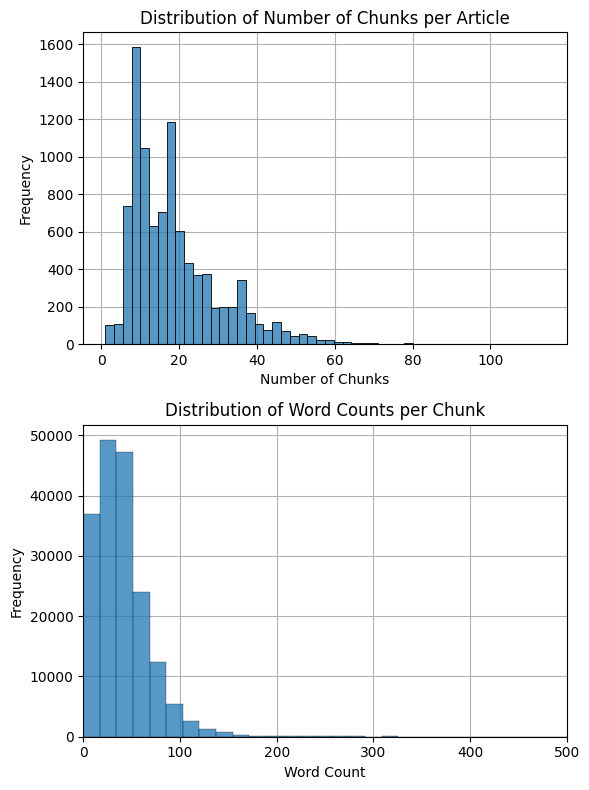

In [12]:
df['content_list'] = df['content'].apply(ast.literal_eval)
df['content_length'] = df['content_list'].apply(len)

df['word_counts_per_chunk'] = df['content_list'].apply(lambda chunks: [len(chunk.split()) for chunk in chunks])
all_word_counts = [word for sublist in df['word_counts_per_chunk'] for word in sublist]

fig, axes = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(df['content_length'], bins=50, ax=axes[0], zorder=2)
axes[0].set_title("Distribution of Number of Chunks per Article")
axes[0].set_xlabel("Number of Chunks")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, zorder=0)

sns.histplot(all_word_counts, bins=150, ax=axes[1], zorder=2)
axes[1].set_title("Distribution of Word Counts per Chunk")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 500)
axes[1].grid(True, zorder=0)

plt.tight_layout()
plt.show()

- The distribution illustrating the number of chunks per article shows a right-skewed distribution. The majority of articles contain fewer than 20 chunks, with a sharp decline in frequency as the number of chunks increases. So most of the documents have around `10-14` chunks in their prechunked content list.

- The second histogram shows an extremely right-skewed distribution of word counts per chunk, with a vast majority of chunks containing very few words — predominantly under 200 words per chunk.
- The sharp drop-off after the first bin and the presence of a very long tail could mean that while most chunks are concise, there are a few chunks with significantly more content. These might represent detailed explanations or comprehensive sections within articles.

### <a id='toc1_3_1_'></a>[Frequency of Publishers](#toc0_)

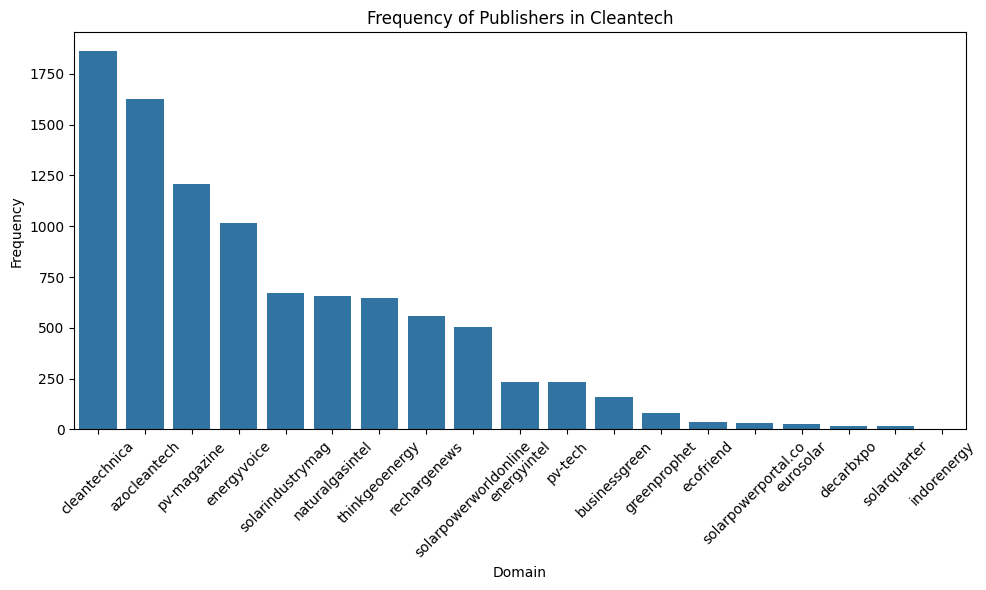

In [17]:
domain_freq = df['domain'].value_counts()
domain_freq = domain_freq.reset_index()
domain_freq.columns = ['domain', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='domain', y='count', data=domain_freq)

plt.title('Frequency of Publishers in Cleantech')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

There's quite a wide range of different publishers in the dataset. Cleantechnica seems to be the most frequent publisher in the set.

## <a id='toc1_4_'></a>[Taking a closer look at titles](#toc0_)
As the summary has shown, only `9569` of the `9593` scraped resources in the dataset have a unique title. This subsection explores if these "duplicate titles" have an underlying error or if these occurences of duplicates can be ignored.

In [169]:
title_freq = df['title'].value_counts()
title_freq = title_freq[title_freq > 1]
title_freq = title_freq.reset_index()
title_freq.columns = ['title', 'count']

title_freq

,title,count
0,Cleantech Thought Leaders Series,5
1,About David J. Cross,5
2,Cleantech Insights from Industry Series,4
3,"Truss, Johnson Join Rebellion Against Sunak fo...",2
4,Staggering potential in next-gen building bloc...,2
5,Royal Opera House drops BP as sponsor after 33...,2
6,Macquarie targets North Sea as the green energ...,2
7,BEIS mulls ringfenced CfD support for geotherm...,2
8,Five ways for the energy industry to shift the...,2
9,Key trends in UK renewables and what to expect...,2


The dataframe shows that there are `16` documents which at least have one duplicate or document with the same name.

Now, lets take a closer look at the contents of the suspected duplicate documents.

In [170]:
def calculate_all_duplicate_document_contents(df, title_freq):
    duplicates_counts = {}

    for title in title_freq['title']:
        duplicate_contents = df[df['title'] == title]['content']
        duplicate_contents = duplicate_contents.apply(ast.literal_eval)
        duplicate_contents = duplicate_contents.explode()
        duplicates_count = duplicate_contents.duplicated().sum()
        duplicates_counts[title] = duplicates_count

    return pd.DataFrame(list(duplicates_counts.items()), columns=['title', 'duplicated_count'])


duplicated_title_contents = calculate_all_duplicate_document_contents(df, title_freq)

duplicated_title_contents

,title,duplicated_count
0,Cleantech Thought Leaders Series,30
1,About David J. Cross,48
2,Cleantech Insights from Industry Series,21
3,"Truss, Johnson Join Rebellion Against Sunak fo...",9
4,Staggering potential in next-gen building bloc...,39
5,Royal Opera House drops BP as sponsor after 33...,10
6,Macquarie targets North Sea as the green energ...,12
7,BEIS mulls ringfenced CfD support for geotherm...,17
8,Five ways for the energy industry to shift the...,15
9,Key trends in UK renewables and what to expect...,10


The function yielded that the duplicate observations of title contain actual duplicate information on chunk-basis.

This could mean that there are even more duplicate chunks under titles that aren't duplicated, so lets next look at that:

In [171]:
df['content'] = df['content'].apply(ast.literal_eval)
df_exploded_contents = df.explode('content')['content']

print(f'Total duplicated contents: {df_exploded_contents.duplicated().sum()}'
      f'\nTotal duplicated contents from duplicated titles: {duplicated_title_contents["duplicated_count"].sum()}'
      f'\nTotal duplicated contents from non-duplicated titles: {df_exploded_contents.duplicated().sum() - duplicated_title_contents["duplicated_count"].sum()}'
      f'\nPercentage of duplicated contents: {df_exploded_contents.duplicated().sum() / len(df_exploded_contents) * 100:.2f}%')

Total duplicated contents: 57929
Total duplicated contents from duplicated titles: 264
Total duplicated contents from non-duplicated titles: 57665
Percentage of duplicated contents: 31.93%


As the result shows, another `57665` chunks on top of the `264` duplicates inside the duplicate-title-occurences emerged. THis is almost a third of all prechunked contents. To see and validate what these duplicates contain, the next step would be to get a closer look at what those chunks contain.

In [172]:
duplicated_content_freq = df_exploded_contents.value_counts()
duplicated_content_freq = duplicated_content_freq[duplicated_content_freq > 1]
duplicated_content_freq = duplicated_content_freq.reset_index()
duplicated_content_freq.columns = ['content', 'count']

duplicated_content_freq.head(10)

,content,count
0,Copyright © 2023 CleanTechnica. The content pr...,1861
1,"This International Women's Day, AZoCleantech s...",1629
2,AZoCleantech recently spoke to entrepreneur Si...,1628
3,"In this interview, AZoCleantech speaks with Te...",1628
4,The Sensi+™ is a laser-based analyzer used for...,1627
5,The Cypher ES AFM from Oxford Instruments Asyl...,1627
6,By clicking `` Allow All '' you agree to the s...,1627
7,The Vocus CI-TOF from TOFWERK provides real-ti...,1627
8,Advertise with CleanTechnica to get your compa...,1505
9,The cookie settings on this website are set to...,1206


The excerpt from the duplicate contents shows that the duplicates mostly stem from sections of websites that got scraped, like **Cookie Banners** or the **Copyright Notice** of CleanTechnica.

Additionally there are contents which contain information which could be important for retrieval. This means inside the `Preprocessor` we will have to drop duplicates but make sure to keep at least one observation since they still contain valuable and queryable information.

## <a id='toc1_5_'></a>[Analyzing Languages](#toc0_)
Since the data seems to mostly be scraped from the web it makes sense to take a look if there are any other recorded languages of contents that might need to get removed to not build in accidental confusion for retrieval.

In [173]:
def safe_detect(text):
    text = str(text)
    try:
        return detect(text)
    except LangDetectException:
        return np.nan


df['language'] = df['content'].apply(safe_detect)
df['language'].value_counts()

language
en    9588
de       4
ru       1
Name: count, dtype: int64

In [174]:
lang_anomlaies = df[(df['language'] == 'ru') | (df['language'] == 'de')]
lang_anomlaies['content']

1251    [EUROSOLAR veranstaltet vom 16. bis 18. März 2...
1271    [EUROSOLAR, the European Association for Renew...
1273    [Die nun zu Ende gegangene „ Internationale Er...
1274    [Photos from the IRES ( Copyright EUROSOLAR e....
2489    [© SMS group liefert Prozesstechnologie für da...
Name: content, dtype: object

As the `5` "language anomalies" show, there seem to also be documents that still contain english.

In this following step we will therefore look if only certain chunks inside these documents contain a non-english language.

In [175]:
non_english_chunks = []

for lang_anomaly in lang_anomlaies['Unnamed: 0'].to_list():
    content = df[df['Unnamed: 0'] == lang_anomaly]['content']
    for chunk in range(len(content.values[0])):
        if detect(content.values[0][chunk]) != 'en':
            non_english_chunks.append((lang_anomaly, chunk))

print(f'Number of anomalies detected: {len(lang_anomlaies.explode("content"))}')
print(f'Number of effective anomaly chunks: {len(non_english_chunks)} ({len(non_english_chunks) / len(lang_anomlaies.explode("content")) * 100:.2f}%)')

Number of anomalies detected: 47
Number of effective anomaly chunks: 23 (48.94%)


The results show that **not every** chunk inside the non-english detected documents is of that anomaly language.